In [1]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/valsp/miniconda3/envs/tf/lib"


In [2]:
import numpy as np
import pickle
from tensorflow import one_hot
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import KLDivergence
from sklearn import metrics
from model_helper import *
from pathlib import Path


2023-04-24 11:51:44.238254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Load in dataset

In [3]:
cwd = Path().cwd()

In [4]:
with open(cwd.parent / "preprocessing/training_seq_n_12_rmrp0", "rb") as f:
    train_data = pickle.load(f)
with open(cwd.parent / "preprocessing/dev_seq_n_12_rmrp0", "rb") as f:
    val_data = pickle.load(f)
with open(cwd.parent / "preprocessing/test_seq_n_12_rmrp0", "rb") as f:
    test_data = pickle.load(f)

In [5]:
X_train = np.array(train_data["X"])
print(f"X_train shape: {X_train.shape}")
Y_train = np.array(train_data["Y"])
print(f"Y_train shape: {Y_train.shape}")
X_val = np.array(val_data["X"])
print(f"X_val shape: {X_val.shape}")
Y_val = np.array(val_data["Y"])
print(f"Y_val shape: {Y_val.shape}")
X_test = np.array(test_data["X"])
print(f"X_test shape: {X_test.shape}")
Y_test = np.array(test_data["Y"])
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (20157, 12, 22)
Y_train shape: (20157,)
X_val shape: (2442, 12, 22)
Y_val shape: (2442,)
X_test shape: (2497, 12, 22)
Y_test shape: (2497,)


## Load Model

In [22]:
GradeNet = load_model("GradeNet")

2023-04-24 12:31:24.692236: W tensorflow/core/common_runtime/graph_constructor.cc:812] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-24 12:31:25.471705: W tensorflow/core/common_runtime/graph_constructor.cc:812] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-24 12:31:26.188778: W tensorflow/core/common_runtime/graph_constructor.cc:812] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-24 12:31:27.286146: W tensorflow/core/common_runtime/graph_constructor.cc:812] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-24 12:31:27.619227: W tensorflow/core/common_runtime/graph_constructor.cc:812] Node 'cond/while' has 13 outputs but 

## 3. Analyze GradeNet Performance

### Confusion Matrix

In [7]:
# TODO: are these actually the metrics documented in their paper? why are they so shit

In [24]:
REGRESSION = True

In [23]:
Y_train_prob = GradeNet.predict(X_train)
Y_val_prob = GradeNet.predict(X_val)
Y_test_prob = GradeNet.predict(X_test)


79/79 [==============================] - 2s 19ms/step


In [27]:
if not REGRESSION:
    Y_train_pred = Y_train_prob.argmax(axis=1)
    Y_val_pred = Y_val_prob.argmax(axis=1)
    Y_test_pred = Y_test_prob.argmax(axis=1)
else:
    Y_train_pred = np.around(Y_train_prob, 0)
    Y_val_pred = np.around(Y_val_prob, 0)
    Y_test_pred = np.around(Y_test_prob, 0)



In [28]:
Y_test_pred

array([[2.],
       [0.],
       [1.],
       ...,
       [2.],
       [0.],
       [1.]], dtype=float32)

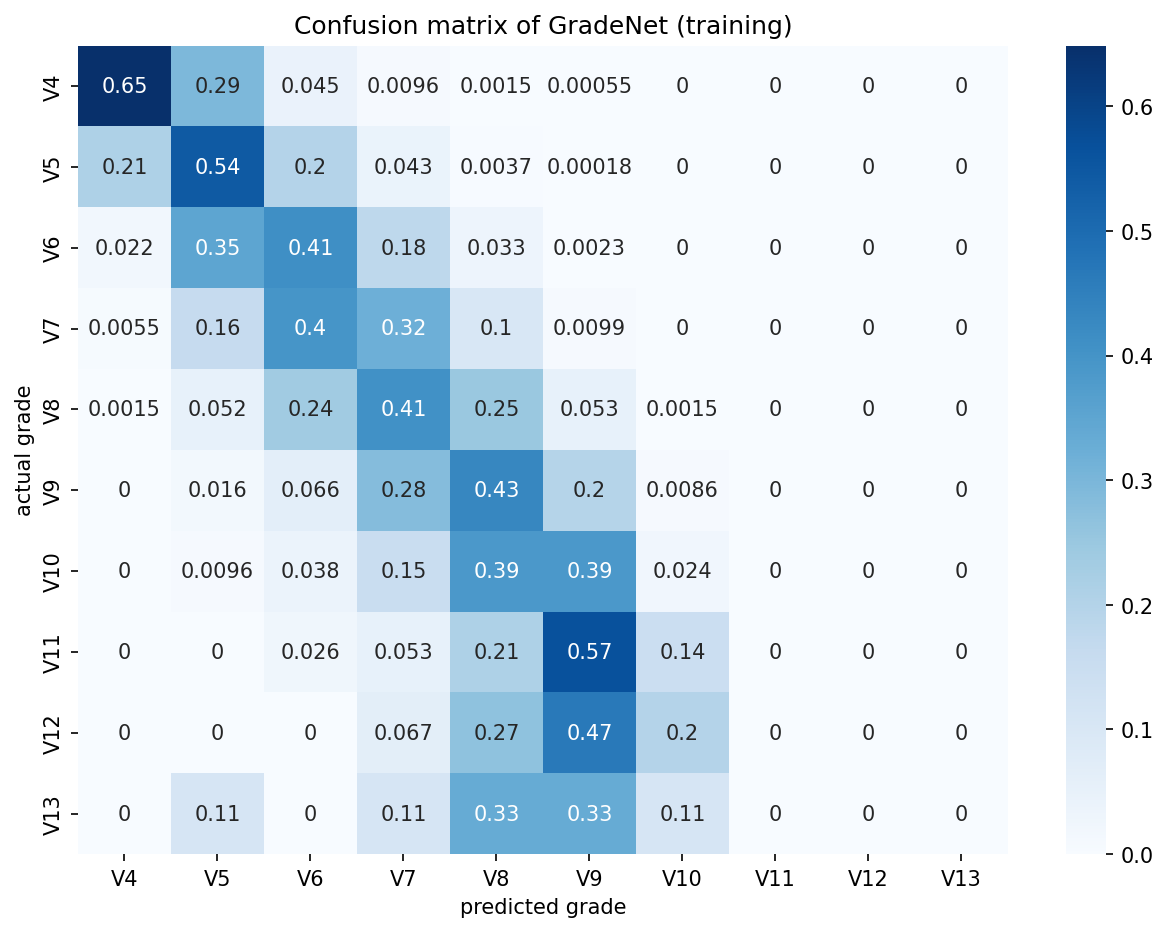

In [29]:
plot_confusion_matrix(Y_train, Y_train_pred, title = 'Confusion matrix of GradeNet (training)')

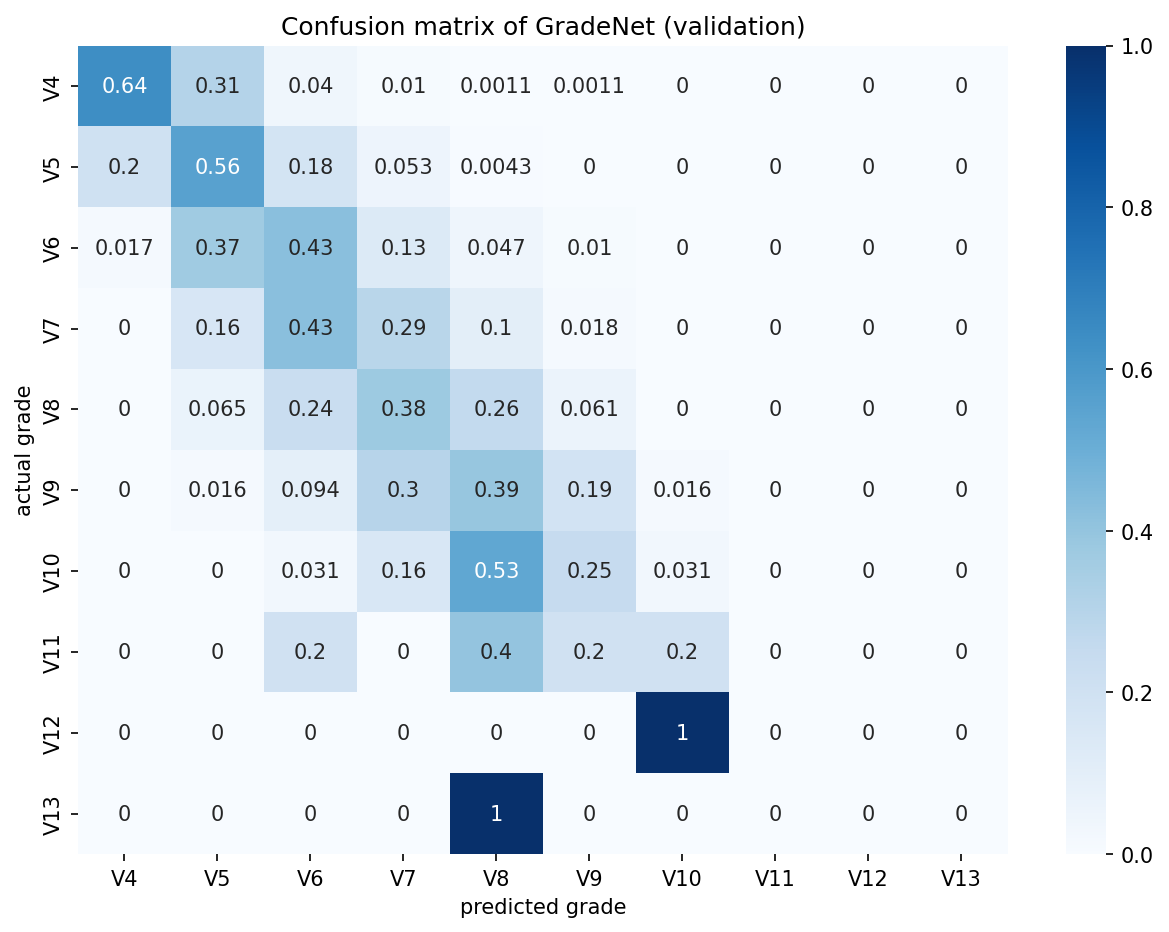

In [30]:
plot_confusion_matrix(Y_val, Y_val_pred, title = 'Confusion matrix of GradeNet (validation)')

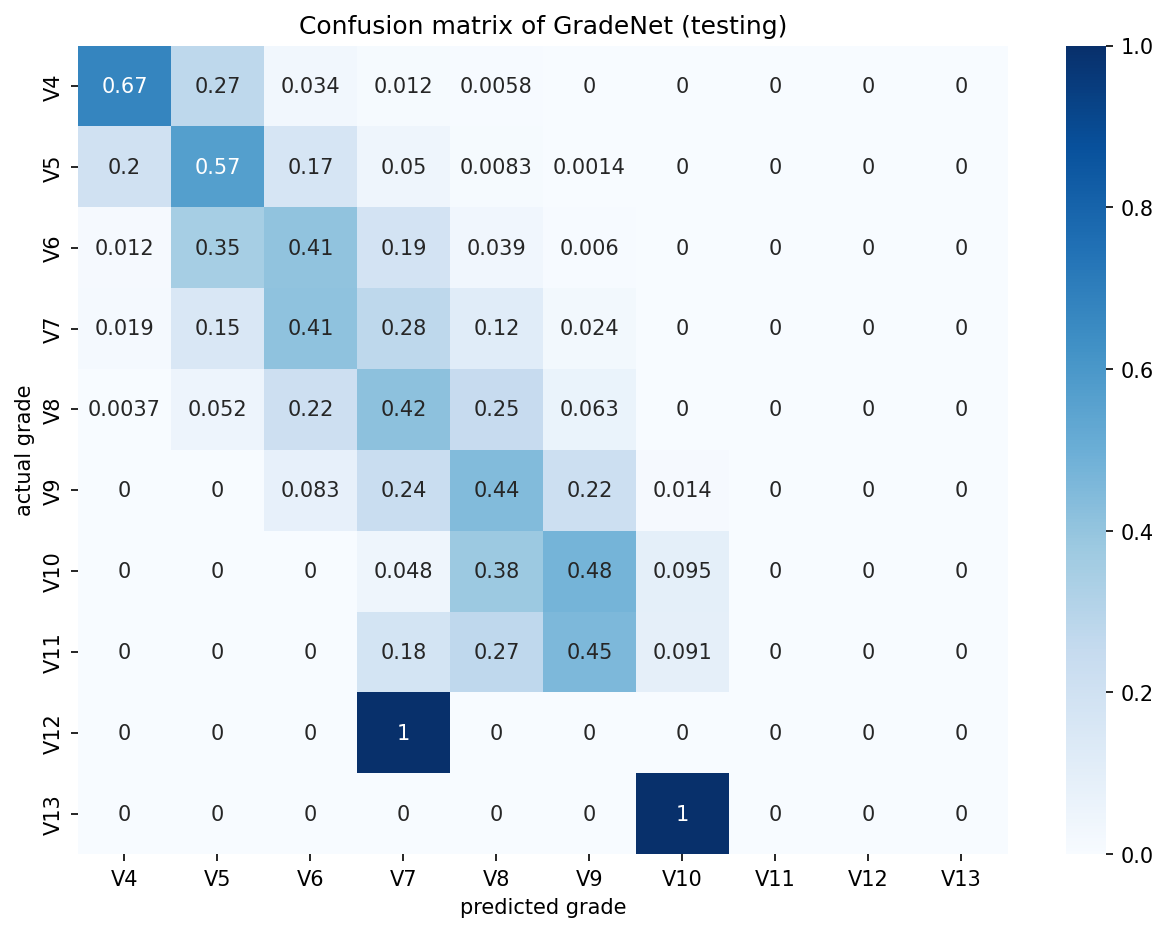

In [31]:
plot_confusion_matrix(Y_test, Y_test_pred, title = 'Confusion matrix of GradeNet (testing)')

### F1 score

In [34]:
F1_train = metrics.f1_score(Y_train, Y_train_pred, average = 'macro')
print(F1_train)

0.24256594378398694


In [33]:
F1_dev = metrics.f1_score(Y_val, Y_val_pred, average = 'macro')
print(F1_dev)

0.24259581705018904


In [32]:
F1_test = metrics.f1_score(Y_test, Y_test_pred, average = 'macro')
print(F1_test)

0.2562064580803761


### Accuracy and Rough accuracy

In [35]:
accuracy_train = compute_accuracy(Y_train, Y_train_pred)
print("Exactly accuracy rate of training set = %s" %accuracy_train[0])
print("+/-1 Accuracy rate of training set= %s" %accuracy_train[1])

Exactly accuracy rate of training set = 4797.331547353277
+/-1 Accuracy rate of training set= 11750.643349704817


In [36]:
accuracy_val = compute_accuracy(Y_val, Y_val_pred)
print("Exactly accuracy rate of dev set = %s" %accuracy_val[0])
print("+/-1 Accuracy rate of dev set = %s" %accuracy_val[1])

Exactly accuracy rate of dev set = 589.9578214578214
+/-1 Accuracy rate of dev set = 1444.2514332514334


In [37]:
accuracy_test = compute_accuracy(Y_test, Y_test_pred)
print("Exactly accuracy rate of test set = %s" %accuracy_test[0])
print("+/-1 Accuracy rate of test set = %s" %accuracy_test[1])

Exactly accuracy rate of test set = 588.2775330396476
+/-1 Accuracy rate of test set = 1446.853023628354


### KL divergence

In [40]:
# TODO: wtf is KL divergence

if not REGRESSION:
    kl = KLDivergence()

    kld_train = kl(one_hot(Y_train.astype(int), depth = 10), Y_train_prob).numpy()
    print(kld_train)

    kld_val = kl(one_hot(Y_val.astype(int), depth = 10), Y_val_prob).numpy()
    print(kld_val)

    kld_test = kl(one_hot(Y_test.astype(int), depth = 10), Y_test_prob).numpy()
    print(kld_test)

### Mean absolute error

In [41]:
# MAE
mae_train = np.mean(np.abs(Y_train - Y_train_pred))
print(mae_train)

mae_val = np.mean(np.abs(Y_val - Y_val_pred))
print(mae_val)

mae_test = np.mean(np.abs(Y_test - Y_test_pred))
print(mae_test)

1.5279110576950352
1.507674527330547
1.5453267188547763


### Classification report

In [42]:
sk_report_train = metrics.classification_report(
    digits=4,
    y_true=Y_train, 
    y_pred=Y_train_pred)
print(sk_report_train)

sk_report_val = metrics.classification_report(
    digits=4,
    y_true=Y_val, 
    y_pred=Y_val_pred)
print(sk_report_val)

sk_report_test = metrics.classification_report(
    digits=4,
    y_true=Y_test, 
    y_pred=Y_test_pred)
print(sk_report_test)

              precision    recall  f1-score   support

         0.0     0.7898    0.6487    0.7123      7285
         1.0     0.4689    0.5438    0.5036      5625
         2.0     0.2856    0.4130    0.3377      2586
         3.0     0.2464    0.3203    0.2785      1811
         4.0     0.4258    0.2489    0.3141      1961
         5.0     0.2992    0.1966    0.2373       580
         6.0     0.1786    0.0239    0.0422       209
         7.0     0.0000    0.0000    0.0000        76
         8.0     0.0000    0.0000    0.0000        15
         9.0     0.0000    0.0000    0.0000         9

    accuracy                         0.4981     20157
   macro avg     0.2694    0.2395    0.2426     20157
weighted avg     0.5269    0.4981    0.5041     20157

              precision    recall  f1-score   support

         0.0     0.7913    0.6399    0.7076       883
         1.0     0.4740    0.5576    0.5124       703
         2.0     0.2864    0.4252    0.3422       301
         3.0     0.2452 

/home/valsp/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/valsp/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/valsp/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v

In [43]:
if not REGRESSION:
    AUC_train = metrics.roc_auc_score(Y_train, Y_train_prob, multi_class= 'ovr', average="macro")
    print(AUC_train)

    AUC_val = metrics.roc_auc_score(Y_val, Y_val_prob, multi_class= 'ovr', average="macro")
    print(AUC_val)

    AUC_test = metrics.roc_auc_score(Y_test, Y_test_prob, multi_class= 'ovr', average="macro")
    print(AUC_test)